# CMPE 480 - Project 3

M. Akın Elden

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from heapq import heappush, heappop
from sklearn import datasets
iris_data = datasets.load_iris()

The data is reformatted for easier usage

In [ ]:
feature_reformat = lambda st : st.replace(' (cm)', '').replace(' ', '_')
feature_names = list(map(feature_reformat, iris_data.feature_names))
iris = pd.DataFrame(iris_data.data, columns=feature_names)
iris["target_class"] = iris_data.target

>**NOTE:** "Imp" means impurity, and "MCE" means misclassification error for all the fields declared in the code

The Node class used to store the decision tree nodes. Each node contains train, validation and test data that fits to the current node. Each one also contains its left and right child nodes if the node is splitted.

In [ ]:
class Node:
    def __init__(self, trainImpurity, trainData, validationData):
        # Train data stored in that node
        self.trainData = trainData
        self.trainSize = len(trainData)
        # Stored train data's impurity value
        self.trainImp = trainImpurity
        grouped = trainData.groupby(["target_class"]).count().iloc[:,0]
        # Dominant class in the stored train data
        self.dominant_class = grouped.idxmax()
        self.trainMCE = misclassificationError(self.trainData, self.dominant_class)
        self.validationData = validationData
        self.validationSize = len(validationData)
        self.validationMCE = misclassificationError(self.validationData, self.dominant_class)
        self.leftChild = None
        self.rightChild = None
        self.hasChild = False
        # In which layer the node is splitted
        self.level = np.inf
        self.testData = None
        self.testMCE = None


    def setTestData(self, testData):
        self.testData = testData
        self.testMCE = misclassificationError(self.testData, self.dominant_class)

    def __lt__(self, other):
        # The node with higher impurity is prioritized in queue
        return self.trainImp > other.trainImp

    def assignLevel(self, level):
        self.level = level

    # Used to split the node and its data with given feature into the childs
    def split(self, feature, value, childDatas, trainImpurities):
        self.splitFeature = feature
        self.splitValue = value
        self.leftChild = Node(trainImpurities[0], childDatas[0], self.validationData[self.validationData[feature]<=value])
        self.rightChild = Node(trainImpurities[1], childDatas[1], self.validationData[self.validationData[feature]>value])
        self.hasChild = True
        del self.trainData, self.validationData # for memory efficiency
        return self.leftChild, self.rightChild

In [ ]:
def entropy(data):
    n = len(data)
    probs = data.groupby(["target_class"]).count().iloc[:,0] / n
    return - np.sum(probs * np.log2(probs))

def informationGain(parentImpurity, childrenData):
    childEntropies = []
    childSizes = []
    for i in range(len(childrenData)):
        d = childrenData[i]
        childEntropies.append(entropy(d))
        childSizes.append(len(d))
    N = np.sum(childSizes)
    if N == 0: # no data given, no improvement
        return 0, childEntropies
    remainder = np.sum( np.array(childEntropies) * np.array(childSizes) / N )
    return parentImpurity - remainder, childEntropies

In [ ]:
def giniIndex(data):
    n = len(data)
    probs = data.groupby(["target_class"]).count().iloc[:,0] / n
    return 1 - np.sum(np.square(probs))

def giniGain(parentImpurity, childrenData):
    childGinis = []
    childSizes = []
    for i in range(len(childrenData)):
        d = childrenData[i]
        childGinis.append(giniIndex(d))
        childSizes.append(len(d))
    N = np.sum(childSizes)
    if N == 0: # no data given, no improvement
        return 0, childGinis
    remainder = np.sum( np.array(childGinis) * np.array(childSizes) / N )
    return parentImpurity - remainder, childGinis

In [ ]:
def misclassificationError(data, predicted_class):
    n = len(data)
    if n == 0:
        # No data, no misclassification error
        return 0
    true_prediction = np.count_nonzero(data["target_class"] == predicted_class)
    return 1 - true_prediction / n    

def lossImprovement(parentMCE, childDatas, childMCEs):
    childSizes = []
    for d in childDatas:
        childSizes.append(len(d))
    N = np.sum(childSizes)
    if N == 0: # no data given, no improvement
        return 0
    weightedMCE = np.sum( np.array(childMCEs) * np.array(childSizes) / N )
    return parentMCE - weightedMCE

The below function iterates all features and their unique values to determine the best split feature and value.

In [ ]:
def findBestSplit(data, parentImp, perfMeasure):
    bestFeature = ""
    bestValue = 0
    bestPerf = 0
    bestChildImps = []
    bestChildData = []
    for c in data.columns[:-1]:
        currentData = data[[c, "target_class"]]
        uniques = currentData[c].unique()
        for v in uniques:
            leftChild = currentData[currentData[c] <= v]
            rightChild = currentData[currentData[c] > v]
            performance, childImps = perfMeasure(parentImp, [leftChild, rightChild])
            if performance > bestPerf:
                bestFeature = c
                bestValue = v
                bestPerf = performance
                bestChildImps = childImps
                bestChildData = [leftChild, rightChild]
    return bestFeature, bestValue, bestPerf, bestChildImps, bestChildData

In [ ]:
def getImpurityMeasurementFunctions(impurityMeasureName):
    impMeasure = None
    perfMeasure = None
    if impurityMeasureName == "entropy":
        impMeasure = entropy
        perfMeasure = informationGain
    elif impurityMeasureName == "gini":
        impMeasure = giniIndex
        perfMeasure = giniGain
    else:
        raise Exception("Invalid impurity measurement")
    return impMeasure, perfMeasure

In [ ]:
def treeGrowth(train, validation, impurityMeasure="entropy"):
    # Impurity measurement functions are determined by parameter
    impMeasure, perfMeasure = getImpurityMeasurementFunctions(impurityMeasure)
    # Each created node is added to a priority queue and
    # the one with highest impurity is prioritized
    nodeQueue = []
    root = Node(impMeasure(train), train, validation)
    heappush(nodeQueue, root)
    # Impurity measurements by each split is stored in list
    totalTrainMCE = [root.trainMCE]
    totalValidMCE = [root.validationMCE]
    totalTrainRow = len(train)
    totalValidRow = len(validation)
    level = 0
    while(len(nodeQueue) > 0):
        currentNode = heappop(nodeQueue)
        if currentNode.trainImp == 0:
            break # all nodes are pure
        currentNode.assignLevel(level)
        feature, value, perf, childImps, childData = findBestSplit(currentNode.trainData, currentNode.trainImp, perfMeasure)
        if perf <= 0:
            continue # no training performance improvement, don't split the node
        leftValidation = currentNode.validationData[currentNode.validationData[feature] <= value]
        rightValidation = currentNode.validationData[currentNode.validationData[feature] > value]
        leftChild, rightChild = currentNode.split(feature, value, childData, childImps)
        trainLossChange = lossImprovement(currentNode.trainMCE, childData, [leftChild.trainMCE, rightChild.trainMCE])
        validationLossChange = lossImprovement(currentNode.validationMCE, [leftValidation, rightValidation], [leftChild.validationMCE, rightChild.validationMCE])
        totalTrainMCE.append(np.round( totalTrainMCE[level] - trainLossChange * currentNode.trainSize / totalTrainRow , 5))
        totalValidMCE.append( np.round( totalValidMCE[level] - validationLossChange * currentNode.validationSize / totalValidRow , 5)) 
        heappush(nodeQueue, leftChild)
        heappush(nodeQueue, rightChild)
        level += 1
    return root, totalTrainMCE, totalValidMCE

In [ ]:
def predictTestData(test, root, split_number):
    # Starting from the root, children are traversed until given number of split is reached
    totalTestRow = len(test)
    root.setTestData(test)
    nodeQueue = []
    heappush(nodeQueue, (root.level, root))
    totalMCE = [root.testMCE]
    leaves = [] # includes the leaf data of test and dominant class at that leaf (coming from training)
    while len(nodeQueue) > 0:
        currentNode = heappop(nodeQueue)[1]
        if currentNode.hasChild == False or currentNode.level>=split_number:
            if currentNode.testData is not None:
                leaves.append( (currentNode.testData, currentNode.dominant_class) )
            continue
        currentData = currentNode.testData
        leftData = currentData[currentData[currentNode.splitFeature] <= currentNode.splitValue]
        rightData = currentData[currentData[currentNode.splitFeature] > currentNode.splitValue]
        leftNode = currentNode.leftChild
        rightNode = currentNode.rightChild
        leftNode.setTestData(leftData)
        rightNode.setTestData(rightData)
        lossChange = lossImprovement(currentNode.testMCE, [leftData, rightData], [leftNode.testMCE, rightNode.testMCE])
        totalMCE.append(np.round( totalMCE[currentNode.level] - lossChange * len(currentNode.testData) / totalTestRow , 5))
        heappush(nodeQueue, (leftNode.level, leftNode) )
        heappush(nodeQueue, (rightNode.level, rightNode) )
    # Calculate the accuracy by calculating true estimates
    true_estimate = 0
    for l in leaves:
        # check if leaf data includes the predicted class
        if np.any(l[0]["target_class"] == l[1]):
            true_estimate += l[0].groupby(["target_class"]).count().loc[ l[1] ][0]
    accuracy = np.array((true_estimate, totalTestRow-true_estimate)).reshape((1,2))
    accuracy_table = pd.DataFrame(data=accuracy, columns=["True estimate","False estimate"], index=["Count"])
    return totalMCE, accuracy_table

In [ ]:
def plotImpurityGraph(trainResults, validationResults, testResults, impurityMeasure, split_number):
    splits = np.arange(len(trainResults))
    plt.figure()
    plt.plot(splits, trainResults, 'k-', label='Training error')
    plt.plot(splits, validationResults, 'b-', label='Validation error')
    plt.plot(splits[:len(testResults)], testResults, 'g-', label='Test error')
    plt.xlabel("Tree depth")
    plt.axvline(split_number, color="r", linestyle='--', label='Pruned depth')
    plt.xticks(splits, splits)
    plt.ylabel("Total MCE")
    if impurityMeasure == "entropy":
        plt.title("Loss with information gain")
    elif impurityMeasure == "gini":
        plt.title("Loss with gini impurity")
    plt.legend()

In [ ]:
def decisionLearning(data, impurityMeasure="entropy", tr_val_te_ratios=[0.2, 0.4, 0.4], seed=480):
    np.random.seed(seed)
    shuffled = data.sample(frac=1)
    N = len(data)
    tr = int(N * tr_val_te_ratios[0])
    val = tr + int(N * tr_val_te_ratios[1])
    training = shuffled[:tr]
    validation = shuffled[tr:val]
    test = shuffled[val:]
    root, trainLoss, validLoss = treeGrowth(training, validation, impurityMeasure)
    # Get the max number of splits which gives the minimum validation error
    split_number = np.where(validLoss == min(validLoss))[0].max()
    testLoss, accuracy = predictTestData(test, root, split_number)
    plotImpurityGraph(trainLoss, validLoss, testLoss, impurityMeasure, split_number)
    return (root, trainLoss, validLoss, testLoss, split_number, accuracy)

**Entropy impurity example**

Test error at pruned depth: 0.28333


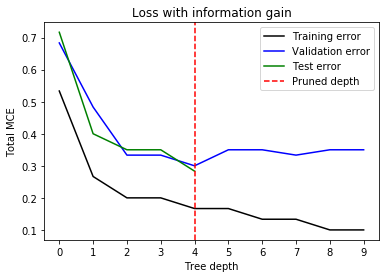

In [ ]:
results = decisionLearning(iris, "entropy", seed=2)
# The last test error value
print("Test error at pruned depth: {0}".format(results[3][-1]))

In [ ]:
results[-1]

,True estimate,False estimate
Count,43,17


**Gini Index impurity example**

0.28333

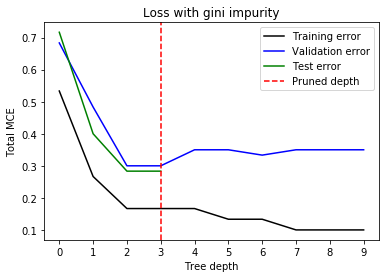

In [ ]:
results = decisionLearning(iris, "gini", seed=2)
# The last test error value
print("Test error at pruned depth: {0}".format(results[3][-1]))

In [ ]:
results[-1]

,True estimate,False estimate
Count,43,17


**10 Random Tree Construction and Tests**

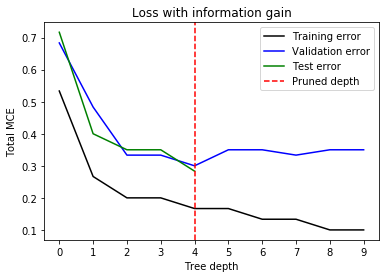

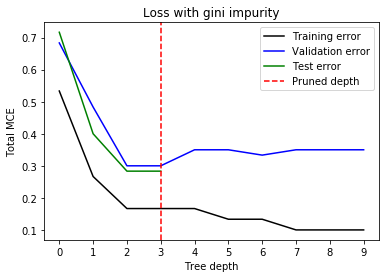

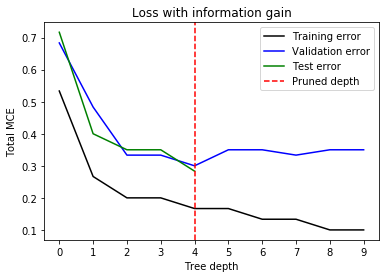

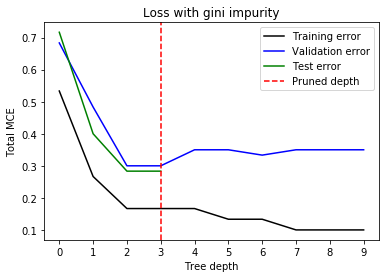

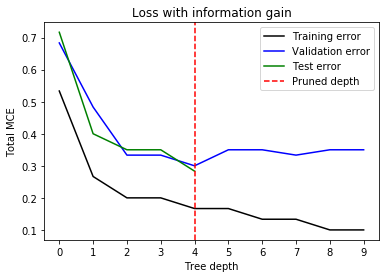

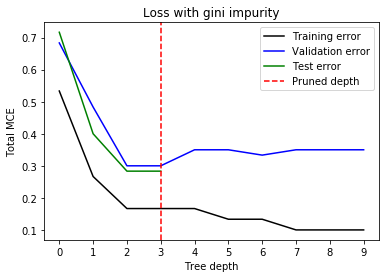

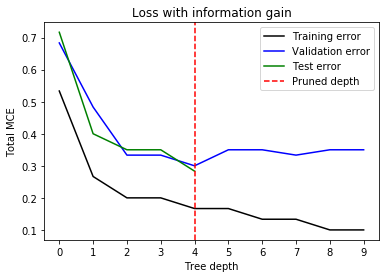

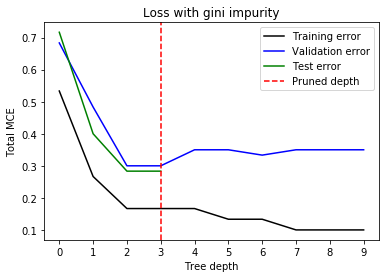

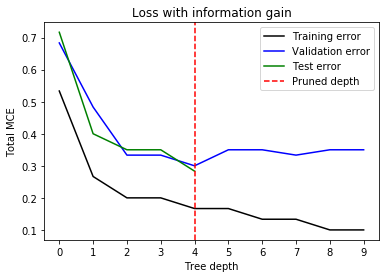

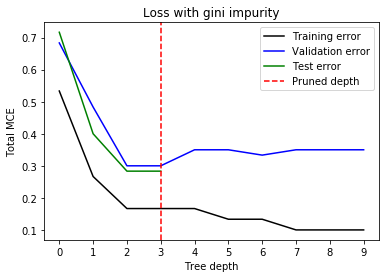

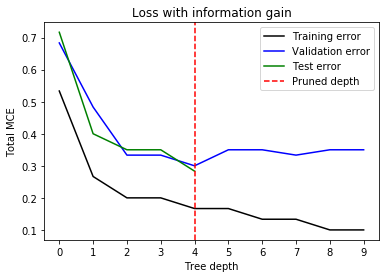

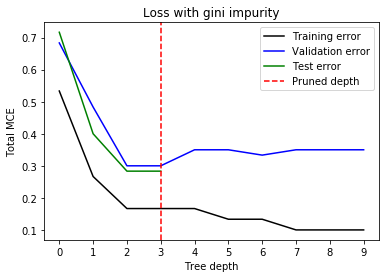

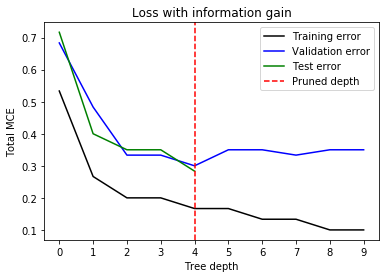

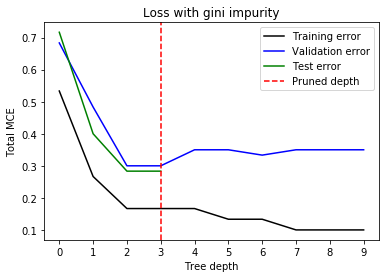

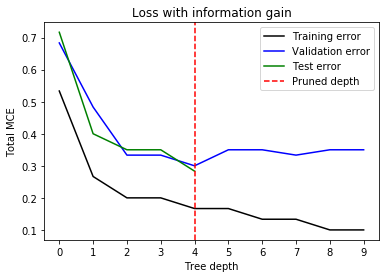

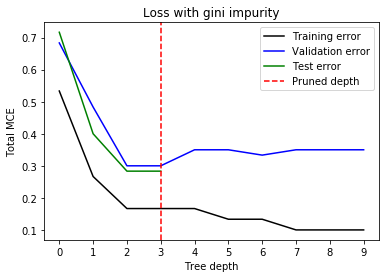

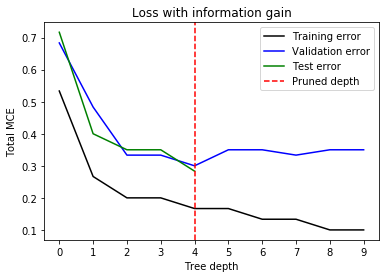

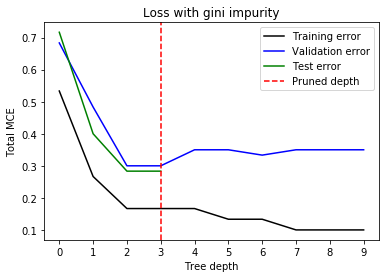

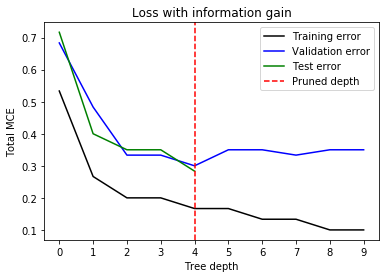

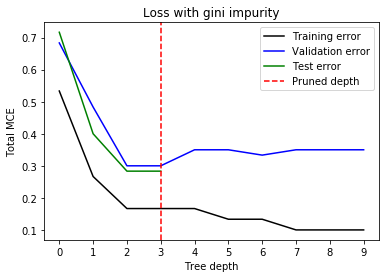

In [ ]:
entropy_results = []
gini_results = []
seed = 2
for i in range(10):
    e_res = decisionLearning(iris, "entropy", seed=seed)
    g_res = decisionLearning(iris, "gini", seed=seed)
    entropy_results.append(e_res[3][-1])
    gini_results.append(g_res[3][-1])

e_mean = np.mean(entropy_results)
e_variance = np.std(entropy_results)

g_mean = np.mean(gini_results)
g_variance = np.std(gini_results)

**Comparison of mean and variances of errors**

In [ ]:
pd.DataFrame([["Entropy",e_mean, e_variance],["Gini",g_mean,g_variance]], columns=["Impurity", "Mean", "Variance"])

,Impurity,Mean,Variance
0,Entropy,0.28333,5.551115e-17
1,Gini,0.28333,5.551115e-17


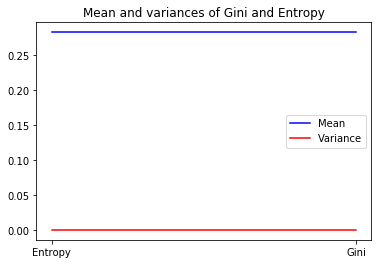

In [ ]:
plt.figure()
plt.title("Mean and variances of Gini and Entropy")
plt.plot(["Entropy","Gini"],[e_mean,g_mean], 'b-', label="Mean")
plt.plot(["Entropy","Gini"],[e_variance,g_variance], 'r-', label="Variance")
plt.legend()
plt.show()